<b style="color:blue;"> 2024 Monthly Retail/Food Sales Prediction <b>

<b style="color:blue;"> By Zohd Khan<b/> 

In this personal project, I develop and employ a <b>Ridge Regression</b> algorithm to predict the <b>average monthly sales value</b> across various types of businesses in America from January to May of 2024. 

I acquired the relevant data from the [US Census Bureau](https://www.census.gov/retail/sales.html), with the source data file being titled "Retail and Food Services Sales (1992-Present)".

I also applied various Data Science techniques, such as <b> seasonal decomposition, cross validation, and algorithmic comparison </b>, to aid in the development and testing of my model.

Throughout the entire coding process, which is provided below, I <b>documented</b> the most significant decisions and analyses that I made while in pursuit of a well-performing model. 

By the end of the process, I finalized an <b>exceptionally accurate</b> model that, with a RMSE score of 25.16 on my test data, was able to make predictions that <b>deviated only .018\% from the true mean sales values, on average.</b> The average RMSE score across 5 folds in Cross-validation was also reasonably low (588.38), indicating the <b>absence of significant overfitting</b>.

&nbsp;&nbsp;

<b style="color:blue;"> Data Loading, Conversion, Storage and Processing</b>

In [1]:
import pandas as pd #Importing "pandas" to perform complex data handling operations, such as the loading, conversion, and processing of the spreadsheets
import numpy as np #Importing "numpy" to perform any essential mathematical operations 

#Initializing file path. I specifically intend to use spreadsheets containing monthly retail data from January 2014 to May of 2024
file_path = "C:/Users/Zohd/OneDrive/Desktop/Personal Project 2/mrtssales92-present.xlsx"

#Initializing function which loads each of the 10 spreadsheets, excludes unneccessary headers/rows, and establishes appropriate headers
def sheets_to_csv(sheet_name):
    df = pd.read_excel( 
        file_path,
        sheet_name = sheet_name,
        skiprows = [0,1,2] + list(range(5,72)) + list(range(111,123)), #Skipping initial headers, unadjusted values, and latter irrelevant comments
        header = None #Setting "header" argument to None since I am about to manually set the header to avoid program errors
    )
    
    # Manually setting headers by taking indexing first two rows, altering NaN values with empty strings, converting both to string type, 
    #joining the 2 rows, stripping whitespaces, and converting everything to a list
    headers = df.iloc[0:2].fillna('').astype(str).apply(' '.join).str.strip().tolist()
    
    #Setting the names of the columns of the dataframes as the headers manually set from above
    df.columns = headers
    
    #Dropping the old first 2 rows as they are no longer needed
    df = df.drop([0,1])
    
    #Setting up the csv file path for every single sheet that is converted
    csv_file_path = f"C:/Users/Zohd/OneDrive/Desktop/Personal Project 2/{sheet_name}_retail_data.csv"
    
    #Using "to_csv" function to convert each sheet to csv file
    df.to_csv(csv_file_path, index = False)
    #print(f"Sheet {sheet_name} successfully converted to CSV.")
    
# Creating the list of sheet names (matching actual names in xlsx file) that will be iterated through to convert sheets to csv filetype
sheet_names = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

#Looping through previous list and applying "sheets_to_csv" function create the new csv files containing the data
for sheet_name in sheet_names: 
    sheets_to_csv(sheet_name)

#print("Conversion from Excel sheets to CSV files completed.")

#Now that csv files are created, writing a seperate function to load them 
def load_csv(file_name):
    df = pd.read_csv(file_name)

    return df
    
#Assigning each of the new csv files an associated csv file path in order to load them in the next step
csv_file_paths = [f"C:/Users/Zohd/OneDrive/Desktop/Personal Project 2/{sheet_name}_retail_data.csv" for sheet_name in sheet_names]

#Applying load_csv function to each csv_file_path and storing the result in retail_data_csv dictionary with sheet_name as the key
retail_data_csv = {sheet_name: load_csv(csv_file_path) for sheet_name, csv_file_path in zip(sheet_names, csv_file_paths)}

#Creating function to transpose each individual DataFrame, add a 'Year' column to keep track of each DataFrame, combine all the DataFrames across rows
def reshape_df(df, year):
    df = df.set_index('Kind of Business').T  # Transposing the DataFrame
    df['Year'] = year  # Adding a Year column
    df = df.reset_index().rename(columns={'index': 'Month'})  # Resetting index and renaming columns
    df = pd.melt(df, id_vars=['Year', 'Month'], var_name='Kind of Business', value_name='Sales')  # Melting the DataFrame
    return df

#Creating retail data list
retail_data_list = []

# Inspecting the first few rows of each dataframe by looping through "retail_data_csv"
for sheet_name, df in retail_data_csv.items():
    #Dropping the "NAICS Code" column as it is useless
    df= df.drop(columns = ["NAICS  Code"])
    #Dropping all rows that are completely filled with NA values
    df = df.dropna(axis = 0, how = 'all')
    #Dropping all columns that are completely filled with NA values
    df = df.dropna(axis = 1, how = 'all')
    #Creating BOOLEAN MASK to check for presence of suppressed values "(S)" in each row, axis = 1 checks across columns (row-wise)
    suppressed_values = df.isin(['(S)']).any(axis = 1)
    #Subsetting each dataframe to select only values that don't contain (S) using "~" tilde NOT operator, so selecting where isin was NOT TRUE
    df = df[~suppressed_values]
    #Applying the reshape function from earlier to 
    reshaped_df = reshape_df(df, sheet_name)
    #
    retail_data_list.append(reshaped_df)
    #Assigning all sheets with the changes I've made through the "df" variable
    retail_data_csv[sheet_name] = df
    

#Concatenating the various dataframes within the "retail_data_csv" dictionary into a single dataframe 
retail_data = pd.concat(retail_data_list, ignore_index=True)

#Resetting index to ensure Python does not get confused with old one 
retail_data.reset_index(drop = True, inplace = True)

# Ensuring correct data types
retail_data['Year'] = retail_data['Year'].astype(str)
retail_data['Month'] = retail_data['Month'].str[:3]
month_mapping = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
retail_data['Month'] = retail_data['Month'].map(month_mapping)
retail_data['Sales'] = pd.to_numeric(retail_data['Sales'], errors='coerce')

# Displaying the concatenated DataFrame shape to ensure all processing was successful
print("Shape of the concatenated DataFrame:", retail_data.shape)

#Printing the retail dataframe, and verifying that all NaN values are gone
print(retail_data.head(6))
print(retail_data.isnull().any())

#Getting the average sales value for each month of each year, by applying "groupby" on year and month, and then finding the average sales value among all
# businesses for each month
retail_data_aggregated = retail_data.groupby(['Year','Month']).agg({'Sales':'mean'}).reset_index()


Shape of the concatenated DataFrame: (4656, 4)
   Year Month                       Kind of Business     Sales
0  2014    01  Retail and food services sales, total  419015.0
1  2014    02  Retail and food services sales, total  424793.0
2  2014    03  Retail and food services sales, total  429132.0
3  2014    04  Retail and food services sales, total  433530.0
4  2014    05  Retail and food services sales, total  434248.0
5  2014    06  Retail and food services sales, total  435438.0
Year                False
Month               False
Kind of Business    False
Sales               False
dtype: bool



This initial section of my code performs the loading, conversion, and storage of the 11 excel spreadsheets to respective CSV files, with each CSV file being associated with a year from <b>2014 to 2024</b>. The code then performs a signficant amount of data processing and cleaning in order to prepare the data for analysis.

To complete this section, I first focused on removing any excel rows that contained unneccessary information, such as certain headers or comments, from each of the 11 spreadsheets. I decided to only keep the rows containing <b>adjusted</b> sales values since those values provide the most insight. I also fixed the formatting of any desired headers, and implemented the logic to assign a csv file to each spreadsheet. I loaded each csv file to a dataframe, and then placed all the dataframes into a <b> dictionary </b> object, with the keys and values being the years in the "sheet_name" list, and the corresponding dataframes, respectively. 

I next reshaped each of the dataframes, specifically by transposing them (switching rows and columns), adjusting their columns, and changing their format from wide to long, all of which helped to maintain a consistent structure and ease future indexing. 

After removing NA and suppressed values, I concatenated (linked) all the cleaned dataframes together to create a new, singular dataframe. I then applied various techniques to my time-related columns, all of which helped organize my data properly. 

I finished this section by calculating the <b>average sales value for each month of each year</b>. To achieve this, I grouped the data by the 'Year' and 'Month' columns, and then calculated the mean sales value for each group, which provided a clear view of the average monthly sales trends across all businesses. The result was stored in a new dataframe, 'retail_data_aggregated', which I would work with for the remainder of the procedure, as this granularity of the data would be most convenient for prediction.

&nbsp;&nbsp;

<b style="color:blue;"> Data Visualization</b>

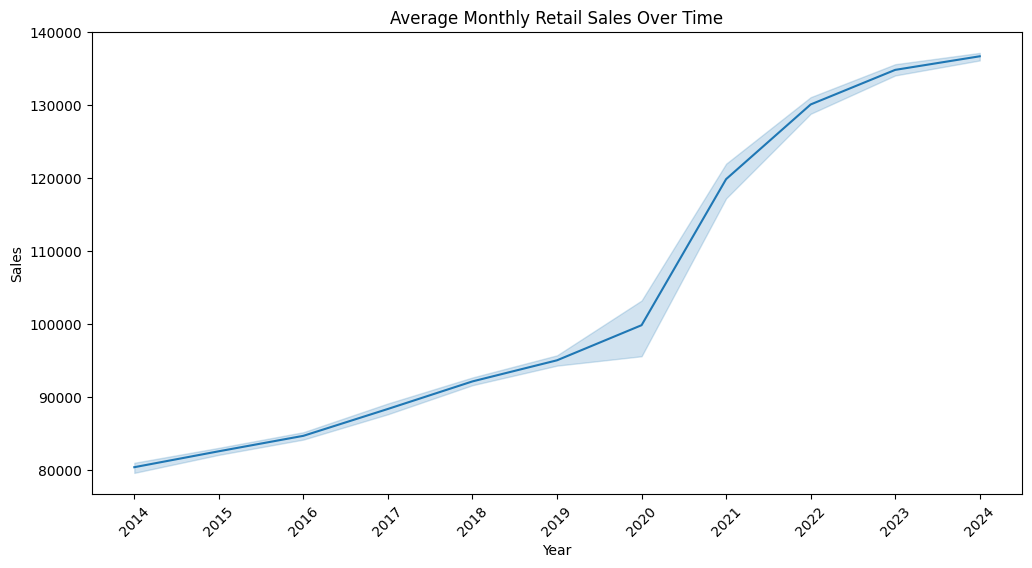

<Axes: xlabel='Average Monthly Retail Sales', ylabel='Frequency'>

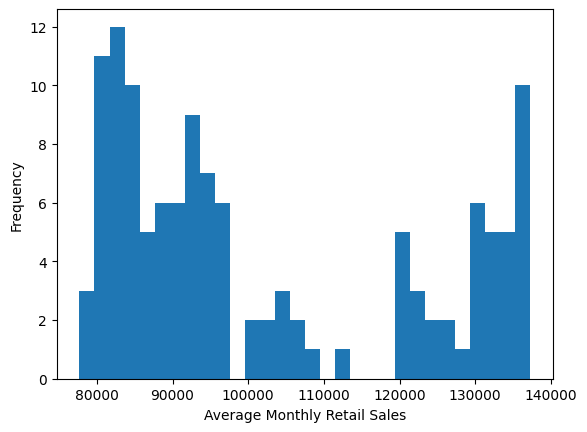

In [2]:
import seaborn as sns #importing seaborn to use "lineplot" function to plot line depicting trend of sales over time 
import matplotlib.pyplot as plt #Using matplotlib for the figure details

#Setting up figure size with width of 12 and length of 6
plt.figure(figsize = (12,6))
#Creating line graph based on aggregated data with years on the x axis and sales on the y axis
sns.lineplot(data = retail_data_aggregated, x = 'Year', y = 'Sales')
plt.title('Average Monthly Retail Sales Over Time')
plt.xticks(rotation = 45)
plt.show()


retail_data_aggregated['Sales'].plot(kind = 'hist', bins = 30, xlabel = 'Average Monthly Retail Sales')
#print(retail_data_aggregated)

This next portion of my code, despite being quite short, still provided some insight into the nature of the processed sales data. Specifically, the line plot shows that the sales across all businesses <b>generally increased</b> over the course of years from 2014 to 2024.

Furthermore, the histogram reveals a <b> multimodal distribution </b> to the data, indicating that the data may be clustered at relatively tight ranges. 

When I first noticed this multimodal distribution, I speculated that it may be due to <b>seasonal effects</b>, which could cause similar sales values to appear during the same months across each year.

In order ascertain whether or not my suspicion was true, I decided to conduct a seasonal decomposition in the next section of the code.


&nbsp;&nbsp;

<b style="color:blue;"> Seasonal Decomposition</b>

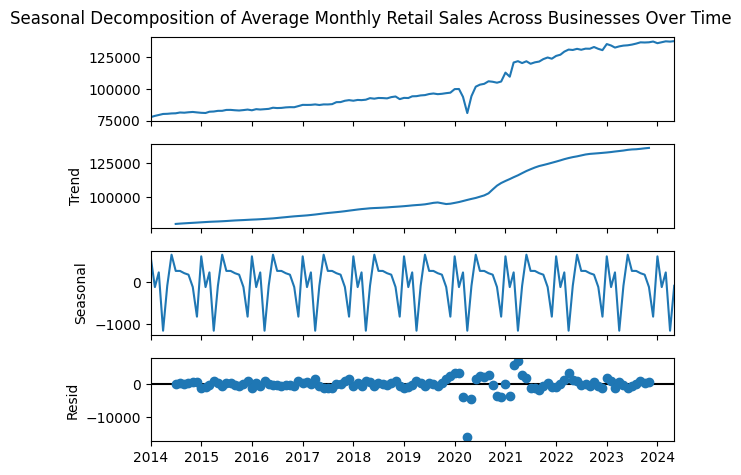

In [3]:
#Importing module that enables execution of seasonal decomposition,which provides insight into the different ways in which retail sales change over time 
from statsmodels.tsa.seasonal import seasonal_decompose 

#Creating new 'date' column that includes concatenation of year and month with hyphen, such as (2024-01). It needs to be in this format as "to_datetime"
#expects this. Also, the reason I am creating this column is to provide a consistent, reliable index for the dataframe
retail_data_aggregated['Date'] = pd.to_datetime(retail_data_aggregated['Year'] + "-" + retail_data_aggregated['Month'])

#Setting the index of the entire "retail_data_aggregated" dataframe to be based on the new 'Date' column since "seasonal_decompose" expects the data
#to be indexed by a certain time interval, with date being appropriate. Also, 'Date' as index eases improves functionality by creating a temporal order 
#that is useful. 
retail_data_aggregated.set_index('Date',inplace = True)

#Applying "seasonal_decompose" function to apply seasonal decomposition to sales of the aggregated retail data. Using additive model, which assumes
#different components add together to create observed data. Based on output, additive model seems preferable because of the
#apparent consistency in seasonal patterns, a well-defined trend, and that the residuals do not show clear patterns (random). 
retail_decomp = seasonal_decompose(retail_data_aggregated['Sales'], model = 'additive')

#Creating new columns in "retail_data_aggregated" dataframe, with each corresponding to one of the 3 components from the seasonal decomposition of sales 
retail_data_aggregated['Trend'] = retail_decomp.trend
retail_data_aggregated['Seasonal'] = retail_decomp.seasonal
retail_data_aggregated['Residual'] = retail_decomp.resid

#Plotting the seasonal decomposition of the monthly retail data from 2014 to mid 2024.
decomp_plot = retail_decomp.plot()
decomp_plot.axes[0].set_title('')
decomp_plot.suptitle('Seasonal Decomposition of Average Monthly Retail Sales Across Businesses Over Time')
plt.show()

A <b> seasonal decomposition </b> is a statistical technique used to break down time series data into its constituent components to better understand and analyze its underlying patterns. 

There are 3 main components to a seasonal decomposition: The <b> trend component </b>, which depicts the general tendency of the data over the given time frame, the <b>seasonal component</b>, which shows the most fitting cyclical pattern that can be attributed to the data, and the <b> residual component</b>, which displays the random variability that remains after the trend and seasonal components are removed. 

The trend and residual plots both indicate a <b>period of irregularity</b> in the data, specifically from March of 2020 to the summer of 2021. This abnormality can be attributed to the COVID-19 pandemic, which caused sales to <b>plunge drastically</b> in March of 2020, only to quickly recover and reach a period of <b>constant fluctuation</b> in the following months, before making <b>another abrupt spike</b> in the summer of 2021. This information is extremely valuable, as upon seeing it, I knew that a specific feature must be fed into my model to account for this time period.   

The seasonal component plot is also insightful, showing that there are <b>peaks</b> (relative maxima) from around March to April and November to December of each year. It also reveals the presence of <b>relative minima</b> during February and October of each year. These findings seem reasonable based on real-life context, as consumers may feel pressured to spend more in the spring on summer essentials, and they also may spend more during the holiday season due to lower prices.   
    
The seasonal plot indicates the need for <b> lag features </b>, which involve using a variable's value at a previous point as a feature in a model at the current time point.

As a result of the seasonal decomposition, I gained a better understanding of potential features that could enhance the overall performance of my model.

&nbsp;&nbsp;

<b style="color:blue;">Descriptive Statistics</b>

In [5]:
pd.set_option('display.max_rows',None)
#print(retail_data_aggregated)
#print(retail_data)
#print(retail_data_aggregated['Sales'].head())
print(retail_data_aggregated['Sales'].describe())
#print(retail_data_aggregated['Sales'].nsmallest(10))

count       125.000000
mean     102228.655734
std       20266.706448
min       77696.236842
25%       84951.394737
50%       93614.783784
75%      123205.972222
max      137288.138889
Name: Sales, dtype: float64


Before beginning the model building process, I quickly examined the <b>descriptive statistics</b> of my target variable (Sales). 

The minimum value of 77696.24 suggested a potential outlier that might need removal, although attempting to do so later unexpectedly decreased model performance. Nevertheless, it is always wise to check the descriptive statistics of your data, as they can provide valuable information. 

&nbsp;&nbsp;&nbsp;&nbsp;



<b style="color:blue;">Review of RMSE <span style="color:red;">(JUST FOR INFORMATIVE PURPOSES)</span> IN THE CASE THAT READER IS UNFAMILIAR WITH THIS CONCEPT</b>


To assess the performance of my Ridge Regression Model, I examine the <b> Root Mean Squared Error (RMSE) </b>, which refers to the square root of the average of the squared differences between the predicted and actual values. 

Let's use a simple example to illustrate the concept of RMSE.

Assume we have both the actual and predicted average sales values across businesses from January to July 2024. 

Actual values: [100,000 , 105,000 , 110,000 , 115,000 , 120,000]

Predicted Values: [102,000, 106,000, 108,000, 116,000, 119,000]

After calculating the differences (errors) between each corresponding actual and predicted value, we obtain [-2000, -1000, 2000, -1000, 1000].

We can take the square of the absolute value of each of these errors to get [4,000,000, 1,000,000, 4,000,000, 1,000,000, 1,000,000]. 

After computing the average of these squared errors, we obtain 2,200,000, which is the Mean Squared Error (MSE). 

However, the MSE's value is in squared units, making it difficult to interpret directly in the context of the original data.  

Therefore, we take the square root of our MSE to obtain 1483.24 as our RMSE. 

This value tells us that, on average, the model's predictions would be off by about 1483.24 units in sales compared to the actual recorded sales values. 

Since the average actual sales value in this example is 110,000, we could conclude that our predictions, on average, deviate from the actual sales values by about 1.3\% of the mean sales value. This would indicate that our model is reasonably accurate.


&nbsp;&nbsp;

<b style="color:blue;">Final Model</b>

In [6]:
from sklearn.metrics import mean_squared_error #Importing "mean_squared_error" function to assess model performance
from sklearn.linear_model import Ridge #Importing ridge regression algorithm to use for the predictive model
from sklearn.model_selection import TimeSeriesSplit, cross_val_score #Importing these functions to check for overfitting via Cross-validation

#Function that adds columns of feature variables to dataframe copy (to preserve original df). 
#pd.to_datetime, by converting columns to datetime format, allows the usage of various #datetime attributes for indexing and feature extraction. 
def retail_features(retail_data_aggregated):
    retail_data_aggregated = retail_data_aggregated.copy() #creating copy of df to perserve original in case of mistake
    retail_data_aggregated['year_feature'] = retail_data_aggregated.index.year #capturing year of each data point to account for yearly trends
    retail_data_aggregated['month_feature'] = retail_data_aggregated.index.month #capturing month of each data point to account for monthly trends
    retail_data_aggregated['quarter_feature'] = retail_data_aggregated.index.quarter #capturing quarter of each data point to account for fiscal trends
    retail_data_aggregated['Lag_1'] = retail_data_aggregated['Sales'].shift(1) #capturing sales value from prev month, aiding in short-term prediction
    retail_data_aggregated['Lag_2'] = retail_data_aggregated['Sales'].shift(2) #capturing sales value from prev month, aiding in short-term prediction
    retail_data_aggregated['Lag_3'] = retail_data_aggregated['Sales'].shift(3) #capturing sales value from prev month, aiding in medium-term prediction
    retail_data_aggregated['Rolling_Mean_3'] = retail_data_aggregated['Sales'].rolling(window=3).mean() #capturing average sales over past 3 months
    #Creating feature to account for period of irregularity between March 2020 and July 2021 due to COVID-19 pandemic
    retail_data_aggregated['COVID_Indicator'] = ((retail_data_aggregated.index >= '2020-03') & (retail_data_aggregated.index <= '2021-07')).astype(int)
    return retail_data_aggregated

# Applying the engineered features to the entire dataset
retail_data_aggregated = retail_features(retail_data_aggregated)

# Handling NaN values with forward fill and bfill, which basically impute empty values with whatever value is above or below the row with empty value
retail_data_aggregated.ffill(inplace=True)
retail_data_aggregated.bfill(inplace=True)

#Cannot use "train_test_split" because I am dealing with time series data here, so order of data points is crucial. 
#train_test_split randomly splits the data, breaking the temporal order and causing potential data leakage
#Instead, applying the "retail_features" function to the train and test subsets from earlier 
train = retail_data_aggregated.loc[retail_data_aggregated.index < '2024-01'].copy()
test = retail_data_aggregated.loc[retail_data_aggregated.index >= '2024-01'].copy()

# Ensuring there are no NaN values in train and test sets
train.dropna(inplace=True)
test.dropna(inplace=True)

# Creaing variables containing the features and the target variable
features = ['year_feature', 'month_feature', 'quarter_feature', 'Lag_1', 'Lag_2', 'Lag_3','Rolling_Mean_3','COVID_Indicator']
target = 'Sales'

# Creating the train and test sets, with both containing the features and target
x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

# Initializing the Ridge Regressor
retail_model = Ridge(alpha=1.0)  # Regularization strength

# Performing 5-fold cross-validation using "TimeSeriesSplit" function
time_series_cv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(retail_model, x_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error') #feeding relevant arguments
cv_scores = -cv_scores  # Converting scores to positive values

#Printing performance metrics for cross validation 
print(f'Cross-validated RMSE scores: {cv_scores}')
print(f'Mean cross-validated RMSE: {np.mean(cv_scores)}')

# Fitting the model on the entire training set
retail_model.fit(x_train, y_train)

# Making predictions on the test set and printing the results/performance metrics
test_predictions = retail_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f'RMSE Score on Test set: {test_rmse:0.2f}')


Cross-validated RMSE scores: [ 374.18895052  473.99775533 1525.73334322  473.968508     93.99435234]
Mean cross-validated RMSE: 588.3765818848949
RMSE Score on Test set: 25.16


To build my final model, I first created a function to create relevant features that could provide insight into my <b>target</b> variable, which is the Average Monthly Sales Across Businesses in America. Most of my features add value by accounting for trends in relation to specific time frames, such a each month or each fiscal quarter. One particularly robust feature is the <b> 3-month rolling average </b>, which calculates the average values for the 3 months preceding a given month. I also included a "COVID_Indicator" feature, which instructed the model to also account for the specific trend that occured during the aforementioned period of irregularity.

After updating my dataframe with the feature variables, I conducted a split of my entire dataset into training and testing sections, with the training section including all months before January 2024, and the testing section including all months after January 2024. I  then assigned my feature and target variables to both these sets. 

Once my training and testing sets were ready, I initialized a Ridge Regressor with an alpha value of 1, which means that <b>L2 Regularization</b> was applied to the model to <b>control overfitting</b> by penalizing large coefficients. 

I finally performed 5-fold cross validation to check for overfitting, and then performed the standard feeding and predicting with my model to assess the results using RMSE.

In [7]:
print(test['Sales'].describe())

count         5.000000
mean     136689.377778
std         652.845741
min      135675.000000
25%      136433.611111
50%      136909.833333
75%      137140.305556
max      137288.138889
Name: Sales, dtype: float64


&nbsp;&nbsp;

<b style="color:blue;">Final Results and Algorithmic Comparison</b>

The test set's RMSE score of <b>25.16</b> indicates that, on average, the Ridge Regression model's predictions for each month's average monthly sales only deviated from the actual values by about <b>.026\%</b> of the mean sales value (136689.377778) for the testing data.

Therefore, this RMSE score reveals that the model is performing very well, as the sales values it predicts are very close to the true values, on average. 

The average RMSE score across the 5 Cross-validation folds of <b>588.38</b> verifies that the model is not significantly overfitting onto the testing data, which means that the exquisite performance is not due to chance. 

While deciding which algorithm to use for my model, I experimented with other options, such as the GradientBoostingRegressor shown below. However, the <b> relative simplicity </b> of the Ridge Regression algorithm ended up working better with my data, which highlights how the complex algorithm is not always the most appropriate one. 

&nbsp;&nbsp;

<b style="color:blue;">Conclusion</b>

Over the course of this personal project, I have gained extensive knowledge of the various processes and techniques that were applied to achieve a well-performing model. 

However, there are undoubtedly other ways in which my procedure could have been improved, such as by dealing with a larger set of data or forecasting into the future. 

Nonetheless, I am glad I completed this project as it helped me get one step closer to my overall goal of becoming a capable Data Scientist. 

Thank you for reading my report, and I hope you enjoyed it. 

In [8]:
from sklearn.metrics import mean_squared_error # Importing "mean_squared_error" function to assess model performance
from sklearn.ensemble import GradientBoostingRegressor # Importing Gradient Boosting Regressor for the predictive model
from sklearn.model_selection import TimeSeriesSplit, cross_val_score # Importing these functions to check for overfitting via Cross-validation

# Function that adds columns of feature variables to dataframe copy (to preserve original df).
# pd.to_datetime, by converting columns to datetime format, allows the usage of various datetime attributes for indexing and feature extraction.
def retail_features(retail_data_aggregated):
    retail_data_aggregated = retail_data_aggregated.copy() # Creating copy of df to preserve original in case of mistake
    retail_data_aggregated['year_feature'] = retail_data_aggregated.index.year # Capturing year of each data point to account for yearly trends
    retail_data_aggregated['month_feature'] = retail_data_aggregated.index.month # Capturing month of each data point to account for monthly trends
    retail_data_aggregated['quarter_feature'] = retail_data_aggregated.index.quarter # Capturing quarter of each data point to account for fiscal trends
    retail_data_aggregated['Lag_1'] = retail_data_aggregated['Sales'].shift(1) # Capturing sales value from prev month, aiding in short-term prediction
    retail_data_aggregated['Lag_2'] = retail_data_aggregated['Sales'].shift(2) # Capturing sales value from 2 months ago, aiding in short-term prediction
    retail_data_aggregated['Lag_3'] = retail_data_aggregated['Sales'].shift(3) # Capturing sales value from 3 months ago, aiding in medium-term prediction
    retail_data_aggregated['Rolling_Mean_3'] = retail_data_aggregated['Sales'].rolling(window=3).mean() # Capturing average sales over past 3 months
    retail_data_aggregated['Rolling_Mean_6'] = retail_data_aggregated['Sales'].rolling(window=6).mean() # Capturing average sales over past 6 months
    # Creating feature to account for period of irregularity between March 2020 and July 2021 due to COVID-19 pandemic
    retail_data_aggregated['COVID_Indicator'] = ((retail_data_aggregated.index >= '2020-03') & (retail_data_aggregated.index <= '2021-07')).astype(int)
    return retail_data_aggregated

# Applying the engineered features to the entire dataset
retail_data_aggregated = retail_features(retail_data_aggregated)

# Handling NaN values with forward fill and bfill, which basically impute empty values with whatever value is above or below the row with empty value
retail_data_aggregated.ffill(inplace=True)
retail_data_aggregated.bfill(inplace=True)

# Cannot use "train_test_split" because I am dealing with time series data here, so order of data points is crucial.
# train_test_split randomly splits the data, breaking the temporal order and causing potential data leakage
# Instead, applying the "retail_features" function to the train and test subsets from earlier
train = retail_data_aggregated.loc[retail_data_aggregated.index < '2024-01'].copy()
test = retail_data_aggregated.loc[retail_data_aggregated.index >= '2024-01'].copy()

# Ensuring there are no NaN values in train and test sets
train.dropna(inplace=True)
test.dropna(inplace=True)

# Creating variables containing the features and the target variable
features = ['year_feature', 'month_feature', 'quarter_feature', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3', 'Rolling_Mean_6', 'COVID_Indicator']
target = 'Sales'

# Creating the train and test sets, with both containing the features and target
x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

# Initializing the Gradient Boosting Regressor with best parameters from GridSearchCV
retail_model = GradientBoostingRegressor(
    n_estimators=300,       # Number of trees
    max_depth=7,            # Maximum depth of each tree
    learning_rate=0.1,      # Learning rate
    subsample=0.9,          # Subsample ratio
    random_state=42         # For reproducibility
)

# Performing 5-fold cross-validation using "TimeSeriesSplit" function
time_series_cv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(retail_model, x_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error') # Feeding relevant arguments
cv_scores = -cv_scores  # Converting scores to positive values

# Printing performance metrics for cross-validation
print(f'Cross-validated RMSE scores: {cv_scores}')
print(f'Mean cross-validated RMSE: {np.mean(cv_scores)}')

# Fitting the model on the entire training set
retail_model.fit(x_train, y_train)

# Making predictions on the test set and printing the results/performance metrics
test_predictions = retail_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f'RMSE Score on Test set: {test_rmse:0.2f}')


Cross-validated RMSE scores: [ 2300.40532089  3793.75172284  5798.14847208 17748.26554873
  3575.2778631 ]
Mean cross-validated RMSE: 6643.169785528118
RMSE Score on Test set: 888.62
